In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

from sklearn.utils import shuffle as _shuffle
from etudes.datasets import make_classification_dataset

In [2]:
# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels

# constants
num_train = 600
num_features = 1
num_index_points = 256

seed = 8888 # set random seed for reproducibility

X_pred = np.linspace(-6., 6., num_index_points).reshape(-1, num_features)

In [14]:
def make_classification(X_p, X_q, shuffle=False, dtype="float64", random_state=None):

    X = np.vstack([X_p, X_q]).astype(dtype)
    y = np.hstack([np.ones(len(X_p)), np.zeros(len(X_q))])

    if shuffle:
        X, y = _shuffle(X, y, random_state=random_state)

    return X, y

In [15]:
class DistributionPair:

    def __init__(self, p, q):

        self.p = p
        self.q = q

    def logit(self, x):

        return self.p.log_prob(x) - self.q.log_prob(x)

    def density_ratio(self, x):

        return tf.exp(self.logit(x))

    def classifer(self, x):

        return tf.sigmoid(self.logit(x))

    def make_dataset(self, num_samples, rate=0.5, dtype="float64", seed=seed):

        num_p = int(num_samples * rate)
        num_q = num_samples - num_p

        X_p = self.p.sample(sample_shape=(num_p, 1), seed=seed).numpy()
        X_q = self.q.sample(sample_shape=(num_q, 1), seed=seed).numpy()

        return make_classification(X_p, X_q, dtype=dtype, random_state=seed)

In [5]:
qs = {
    "same": tfd.Normal(loc=0.0, scale=1.0),
    "scale_lesser": tfd.Normal(loc=0.0, scale=0.6),
    "scale_greater": tfd.Normal(loc=0.0, scale=2.0),
    "loc_shift": tfd.Normal(loc=0.5, scale=1.0),
    "additive": tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[0.95, 0.05]),
        components_distribution=tfd.Normal(loc=[0.0, 3.0], scale=[1.0, 1.0])),
    "bimodal": tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[0.4, 0.6]),
        components_distribution=tfd.Normal(loc=[2.0, -3.0], scale=[1.0, 0.5]))
}

In [6]:
p = tfd.Normal(loc=0.0, scale=1.0)
pairs = {name: DistributionPair(p, q) for name, q in qs.items()}

In [7]:
pairs

{'same': <__main__.DistributionPair at 0x7f4cc6052cf8>,
 'scale_lesser': <__main__.DistributionPair at 0x7f4cc6052e80>,
 'scale_greater': <__main__.DistributionPair at 0x7f4cc6052898>,
 'loc_shift': <__main__.DistributionPair at 0x7f4cc60526a0>,
 'additive': <__main__.DistributionPair at 0x7f4cc6052828>,
 'bimodal': <__main__.DistributionPair at 0x7f4cc6052780>}

In [8]:
def plot_densities(x, pair, ax=None):

    ax.plot(x, pair.q.prob(x), label='$q(x)$')
    ax.plot(x, pair.p.prob(x), label='$p(x)$')

    ax.set_xlabel('$x$')
    ax.set_ylabel('density')

    ax.legend()

In [9]:
def plot_logit(x, pair, ax=None):

    ax.plot(x, pair.logit(x), 'k-')

    ax.set_xlabel('$x$')
    ax.set_ylabel(r"$\log p(x) - \log q(x)$")

In [10]:
def plot_density_ratio(x, pair, ax=None):

    ax.plot(x, pair.density_ratio(x), 'k-')

    ax.set_xlabel('$x$')
    ax.set_ylabel(r"$p(x) / q(x)$")

    ax.set_ylim(0, 3)

In [11]:
def plot_dataset(X_train, y_train, ax=None):

    ax.scatter(X_train, y_train, c=y_train, s=12.**2, 
               marker='s', alpha=0.1, cmap='coolwarm_r')

    ax.set_xlabel('$x$')

    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['$x_q \sim q(x)$', 
                        '$x_p \sim p(x)$'])

In [12]:
def plot_classifier(x, pair, ax=None):

    ax.plot(x, pair.classifer(x), 'k-')

    ax.set_xlabel('$x$')

    ax.set_ylim(-0.05, 1.05)
    # ax2.set_ylabel('$\mathcal{P}(y=1 \mid x)$')
    ax.set_ylabel('$\pi(x)$')

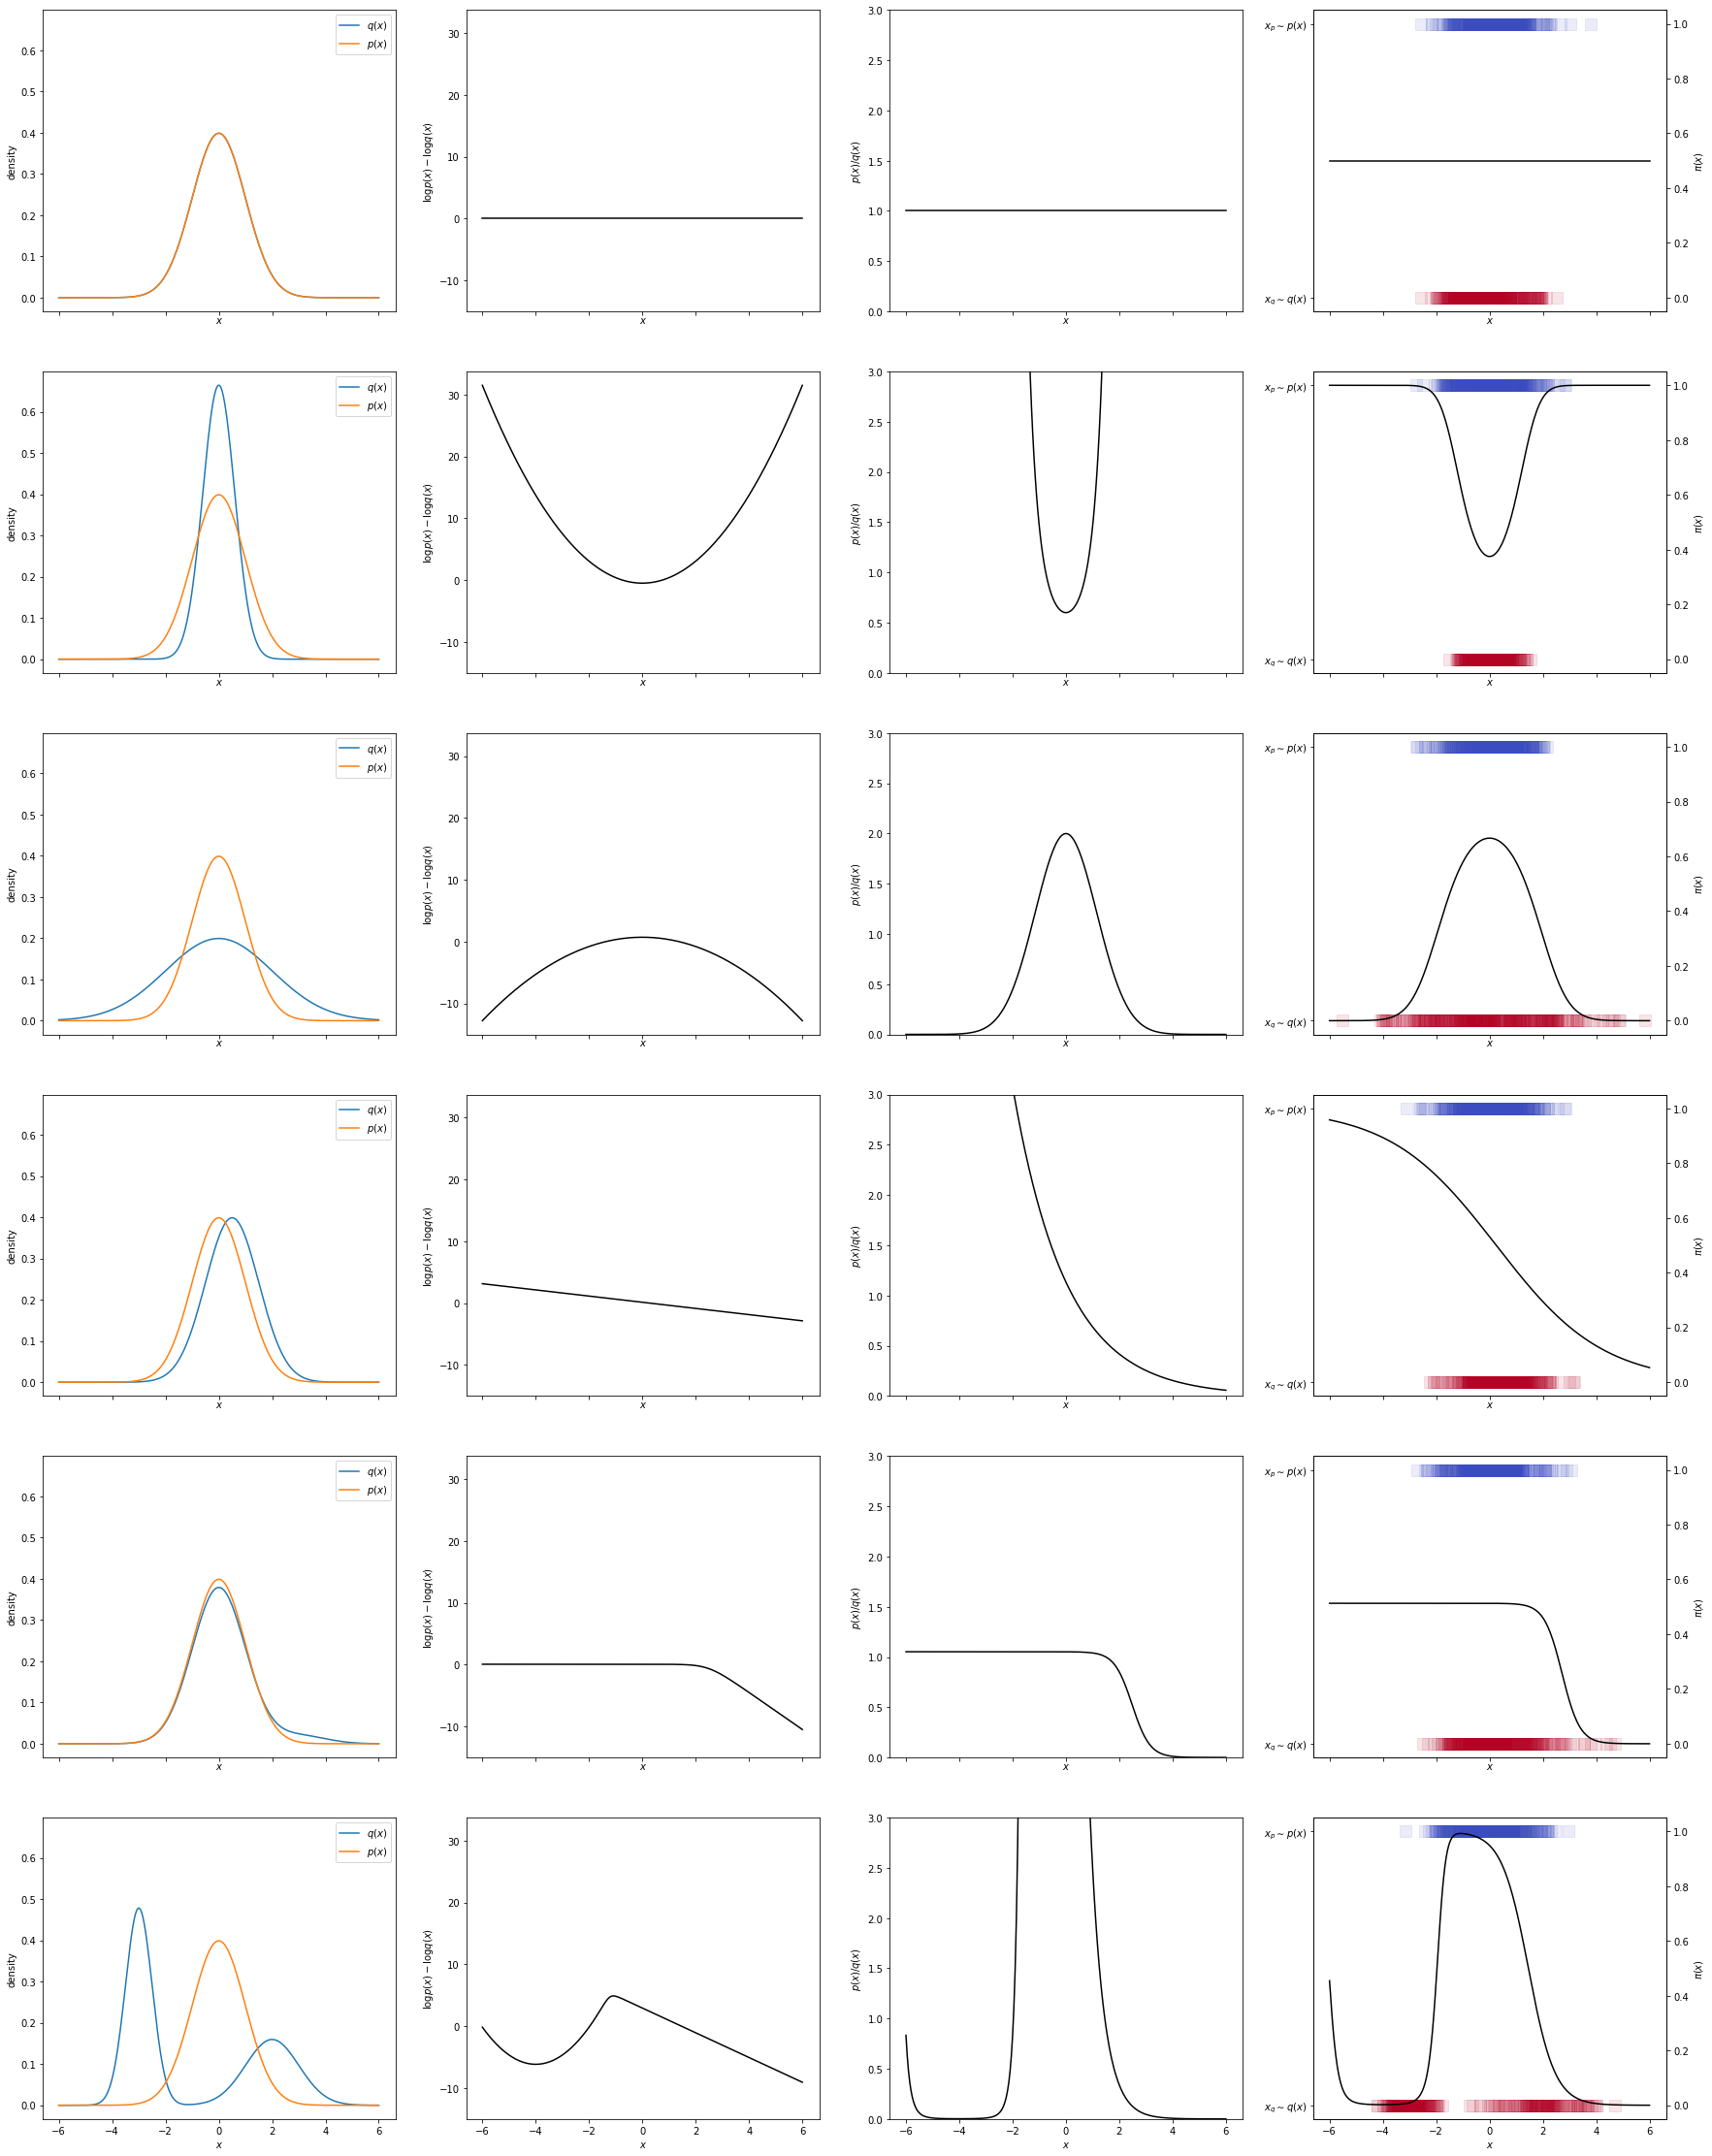

In [13]:
fig, ax_rows = plt.subplots(nrows=len(pairs), ncols=4, figsize=(30, 40),
                            sharex=True, sharey="col")

for (name, pair), (ax1, ax2, ax3, ax4) in zip(pairs.items(), ax_rows):

    X_train, y_train = pair.make_dataset(num_train)

    plot_densities(X_pred, pair, ax=ax1)
    plot_logit(X_pred, pair, ax=ax2)
    plot_density_ratio(X_pred, pair, ax=ax3)
    plot_dataset(X_train, y_train, ax=ax4)

    ax5 = ax4.twinx()

    plot_classifier(X_pred, pair, ax=ax5)

plt.show()